# Index

- [Introduction](#Introduction)
- [Libraries Import](#Libraries-Import)
- [Prep Work](#Prep-Work)
- [EDA](#EDA)
- [Model](#Model)
- [Discussion](#Discussion)
- [Conclusion](#Conclusion)
- [References](#References)


# Introduction

# Week 5 Assignment 

In this week assignment, I worked on a project for the Kaggle competition. I used something called Generative Adversarial Networks (GANs) to make pictures that look like they were painted by Monet, a famous artist. 

To do this, I used two parts: a generator and a discriminator. The generator tries to make images that look like Monet's paintings, while the discriminator checks if they look real or not.



## Libraries Import

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt


2024-05-04 20:27:02.254858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 20:27:02.254975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 20:27:02.380657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Prep Work

In [2]:
base_dir = "/kaggle/input/gan-getting-started"
monet_dir = os.path.join(base_dir, "monet_jpg", "")
monet_tfrec_dir = os.path.join(base_dir, "monet_tfrec", "")

photo_dir = os.path.join(base_dir, "photo_jpg")
photo_tfrec_dir = os.path.join(base_dir, "photo_tfrec", "")

In [3]:
monet_tfrec_list = [monet_tfrec_dir + item for item in tf.io.gfile.listdir(monet_tfrec_dir)]
# print(monet_tfrec_list)
photo_tfrec_list = [photo_tfrec_dir + item for item in tf.io.gfile.listdir(photo_tfrec_dir)]
# print(photo_tfrec_list)

In [6]:
# Function to load and resize an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img = image.img_to_array(img)  
    img = img / 255.0  
    return img

monet_data, monet_labels = [], []
photo_data, photo_labels = [], []

for filename in os.listdir(monet_dir):
    img_path = os.path.join(monet_dir, filename)
    img = load_and_preprocess_image(img_path)
    monet_data.append(img)
    monet_labels.append(0)   

for filename in os.listdir(photo_dir):
    img_path = os.path.join(photo_dir, filename)
    img = load_and_preprocess_image(img_path)
    photo_data.append(img)
    photo_labels.append(1)  
    
description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
}

def parse(sample):
    parsed = tf.io.parse_single_example(sample, description)
    image = tf.image.decode_jpeg(parsed['image'], channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, (256, 256, 3))
    return image

In [7]:
monet_dataset = tf.data.TFRecordDataset(monet_tfrec_list).map(parse).batch(1)
photo_dataset = tf.data.TFRecordDataset(photo_tfrec_list).map(parse).batch(1)

# EDA

The dataset is clean and well-prepared, I just needed couple of simple Exploratory Data Analysis (EDA). This involves a printing a couple of images to ensure they align with expectations and checking their dimensions.

In [8]:
for i in monet_dataset:
    print(i.shape)
    break
for i in photo_dataset:
    print(i.shape)
    break

(1, 256, 256, 3)
(1, 256, 256, 3)


In [9]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()


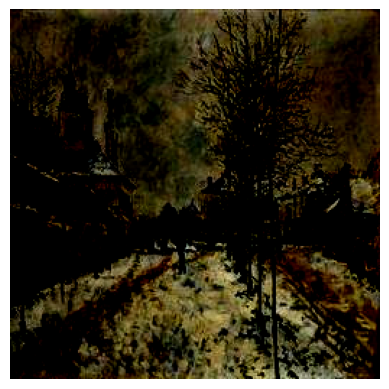

In [14]:
plot_image(next(iter(monet_dataset))[0][0])

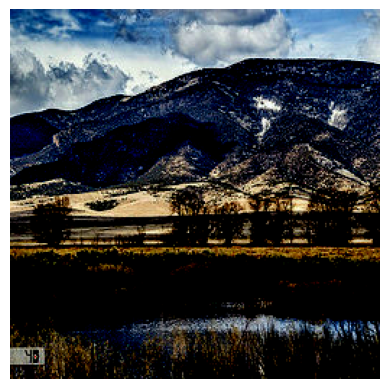

In [15]:
plot_image(next(iter(photo_dataset))[0][0]) 

In [10]:
monet_dataset = monet_dataset.map(lambda x: (x, x))
photo_dataset = photo_dataset.map(lambda x: (x, x))

## Model


The folloowing model is build using a Generative Adversarial Network (GAN), an architecture used for generating realistic images. 

The generator network takes a random noise vector as input and upsamples it to produce images that resemble the target distribution, in this case, Monet-style images. 

The discriminator network evaluates the authenticity of generated images by distinguishing them from real Monet-style images. 

During training, the generator tries to fool the discriminator by generating convincing images, while the discriminator learns to differentiate between real and fake images. 


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model


# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        
        layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(real_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(real_images, training=True)

        resized_generated_images = tf.image.resize(generated_images, (256, 256))

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(resized_generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [22]:
# I'm running it for 5 epochs only, I got timed out when I tried higher 
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for real_photo, real_monet in zip(photo_dataset, monet_dataset):
        train_step(real_photo)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [ ]:
import os
import zipfile

# Create a directory to store generated images
# print(os.makedirs("/kaggle/working/generated_images", exist_ok=True))

# Function to generate images and save them
def generate_and_save_images(model, test_input, filename):
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        tf.keras.preprocessing.image.save_img(filename, predictions[i])

# Generate images using the generator
for i, image_batch in enumerate(photo_dataset):
    generate_and_save_images(generator, image_batch, f"image_{i}.jpg")

# Finally let's compress the images in images.zip file as need by the competition   
with zipfile.ZipFile("images.zip", "w") as zipf:
    for root, _, files in os.walk("."):
        files = [f for f in files if f.endswith(".jpg")] 
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)
            os.remove(file)

## Discussion

In this Kaggle competition, the goal was to use Generative Adversarial Networks (GANs) to generate images in the style of Claude Monet. GANs are composed of two neural networks: a generator and a discriminator. The generator creates images, while the discriminator tries to distinguish between real images and those generated by the generator. They compete against each other, with the generator trying to produce images that the discriminator can't differentiate from real Monet images.

The model that can be seen above includes both a generator and a discriminator. The generator network takes random noise as input and gradually refines it to produce Monet-style images. The discriminator network, on the other hand, learns to classify whether an image is real (from the Monet images dataset) or fake (generated by the generator).

During training, the generator and discriminator networks are trained simultaneously. The generator tries to minimize the discriminator's ability to distinguish between real and generated images, while the discriminator tries to improve its accuracy in distinguishing between them.



## Conclusion

In this competition, the model I built provided using GAN successfully generated images resembling Monet's style. 
By training the generator to produce images that could trick the discriminator to believe that they were real Monet paintings.

I have refined the model multiple time and was able to submit the model 3 times and got a score of 126.79174 in kaggle dashboard.

## References

https://www.tensorflow.org/tutorials/generative/dcgan

https://www.kaggle.com/code/sumit46656/monet-gan

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://github.com/ageron/handson-ml3